In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
file = 'C:\\Users\\R44063\\OneDrive - E.ON\\_VSCode\\Projekt Udacity\\data\\raw\\PurchaseOrders.csv'
df = pd.read_csv(file, sep=';', encoding='utf-8') # Good Polish encoding

In [3]:
# Convert dates to datetime64[ns]
df['Req Delivery Date'] = pd.to_datetime(df['Req Delivery Date'], dayfirst=True)
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], dayfirst=True)

# Today's date as pandas Timestamp (datetime64[ns]) with time zeroed (00:00:00)
today = pd.to_datetime('today').normalize()

# Calculate delay in days
df['Delay (days)'] = (df['Delivery Date'] - df['Req Delivery Date']).dt.days

# Condition 1: Requested delivery date was more than 2 days ago and delivery has not occurred
condition_1 = (
    (df['Req Delivery Date'] < (today - pd.Timedelta(days=2))) &
    (df['Delivery Date'].isna())
)

# Condition 2: Delivery date is more than 2 days later than requested delivery date
condition_2 = (
    df['Delivery Date'].notna() &
    ((df['Delivery Date'] - df['Req Delivery Date']) > pd.Timedelta(days=2))
)

# Condition 3: Delivery completed status = NO (i.e., incomplete)
condition_3 = (
    df['Delivery Completed'].str.upper() == 'NO'
)

# Final binary column 'Delayed'
df['Delayed'] = ((condition_1 | condition_2 | condition_3)).astype(int)

In [4]:
# Display the DataFrame
df

,Purchasing Document,Item,Req Delivery Date,Delivery Date,Delivery Completed,Requisitioner,Created By,Supplier,Material Group,Terms of Payment,Delay (days),Delayed
0,4500093085,10,2025-06-06,2025-06-06,Yes,A72755,M89400,42513214,C492005,Y016,0.0,0
1,4500045759,10,2024-12-31,2024-02-29,No,D40969,S64912,42471833,C613500,Y009,-306.0,1
2,4500091628,10,2025-06-05,NaT,No,A72755,M89400,42513214,C492005,Y016,NaN,1
3,4500045943,10,2024-01-31,2024-01-23,No,J60975,B26557,42473253,C551000,Y016,-8.0,1
4,4500090106,10,2025-05-14,NaT,No,M85771,A44167,41019592,C640500,YEM3,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
28650,4500054156,30,2024-05-07,2024-10-25,No,A72401,B26557,61001220,C530505,Y016,171.0,1
28651,4500054156,10,2024-05-07,2024-10-25,No,A72401,B26557,61001220,C530505,Y016,171.0,1
28652,4500054156,20,2024-05-07,2024-10-25,No,A72401,B26557,61001220,C530505,Y016,171.0,1
28653,4500089337,10,2025-12-31,NaT,No,M85771,A44167,61001523,C683000,Y004,NaN,1


In [5]:
# Select features for the model
X = df[["Requisitioner", "Supplier", "Material Group", "Terms of Payment"]]

# Target variable (label) indicating whether delivery is delayed
y = df["Delayed"]

In [6]:
# Encode categorical features using one-hot encoding
X_encoded = pd.get_dummies(X)
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [7]:
# Initialize the Random Forest classifier
model = RandomForestClassifier()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = model.predict(X_test)

In [8]:
# Print the classification report to evaluate model performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2189
           1       0.93      0.90      0.91      3542

    accuracy                           0.89      5731
   macro avg       0.89      0.89      0.89      5731
weighted avg       0.90      0.89      0.89      5731



In [9]:
cm = confusion_matrix(y_test, y_pred)

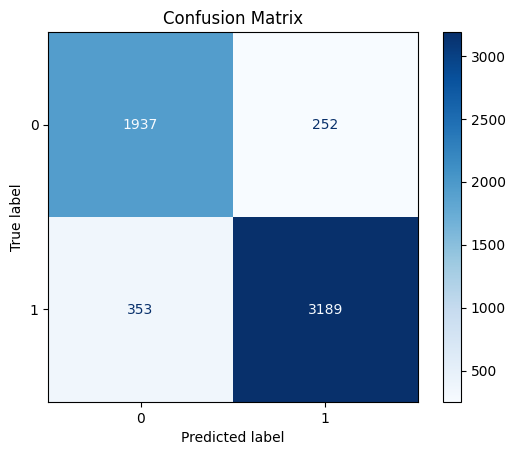

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')  # możesz zmienić kolory, np. 'Oranges', 'Greens'
plt.title("Confusion Matrix")
plt.show()

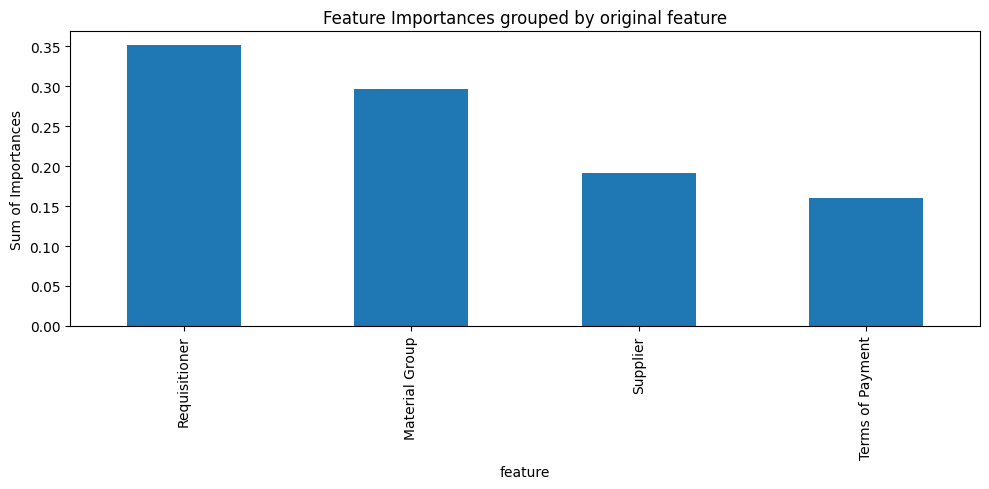

In [12]:
# DataFrame with feature names and their importance scores
features = X_train.columns
feature_importances = model.feature_importances_

feat_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# Extract the "base" feature name before one-hot encoding
feat_df['feature'] = feat_df['feature'].apply(lambda x: x.split('_')[0])

# Sum the importances for each original feature by grouping by the base feature name
grouped = feat_df.groupby('feature')['importance'].sum().sort_values(ascending=False)

# Bar plot of grouped feature importances
plt.figure(figsize=(10,5))
grouped.plot(kind='bar')
plt.title('Feature Importances grouped by original feature')
plt.ylabel('Sum of Importances')
plt.tight_layout()
plt.show()


In [ ]:
importances = model.feature_importances_
feature_names = X_encoded.columns

# 2. DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

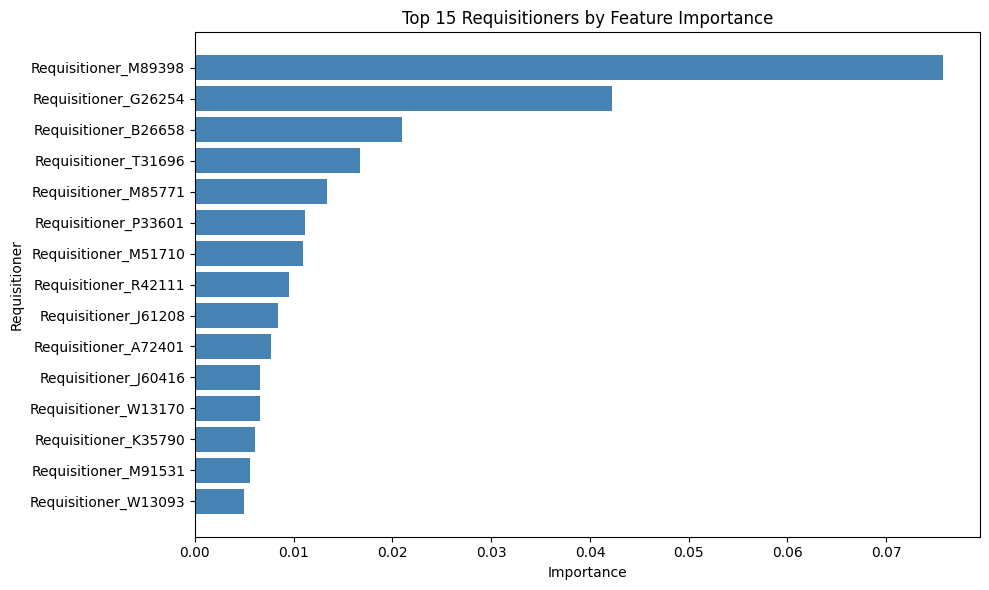

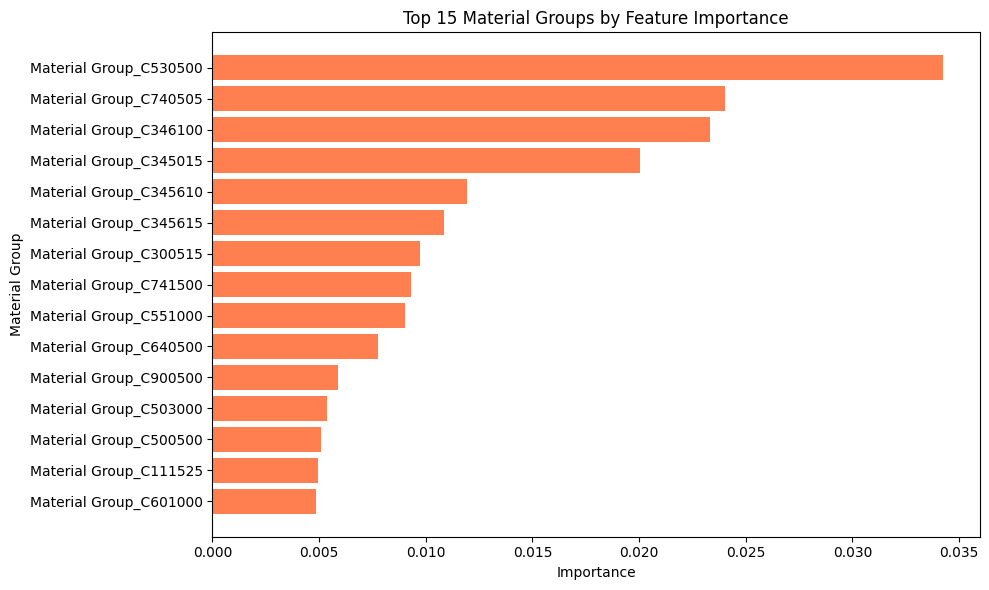

In [ ]:
# Prepare data for the plot for Requisitioner
top_requisitioners = requisitioner_importance.head(15)
features_req = top_requisitioners['Feature']
importances_req = top_requisitioners['Importance']

# Prepare data for the plot for Material Group
material_importance = feature_importance_df[
    feature_importance_df['Feature'].str.startswith('Material Group_')
].sort_values(by='Importance', ascending=False)

top_material = material_importance.head(15)
features_mat = top_material['Feature']
importances_mat = top_material['Importance']

# Plot for Requisitioner
plt.figure(figsize=(10, 6))
plt.barh(features_req, importances_req, color='steelblue')
plt.gca().invert_yaxis()  # Reverse Y-axis so the highest importance is on top
plt.title('Top 15 Requisitioners by Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Requisitioner')
plt.tight_layout()
plt.show()

# Plot for Material Group
plt.figure(figsize=(10, 6))
plt.barh(features_mat, importances_mat, color='coral')
plt.gca().invert_yaxis()  # Reverse Y-axis so the highest importance is on top
plt.title('Top 15 Material Groups by Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Material Group')
plt.tight_layout()
plt.show()
